<a href="https://colab.research.google.com/github/NandaGoplalNaskar/Pytorch/blob/main/PINNs_25_11_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import numpy as np
import os
import requests
from time import perf_counter
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
from IPython.display import display

# Determine computation device: Use GPU if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



## Example 1: Solving a Single Ordinary Differential Equation (ODE)

Consider the ode:
$$
\frac{d\Psi}{dx} = f(x, \Psi),
$$
with $x \in [0,1]$ and initial conditions (IC):
$$
\Psi(0) = A.
$$
We write the trial solution by:
$$
\hat{\Psi}(x; \theta) = A + x N(x; \theta),
$$
where $N(x; \theta)$ is a neural network (NN).
The solution is $\hat{\Psi}(x;\theta)$ automatically satisfied the initial conditions.
The loss function we would like to minimize to train the NN is:
$$
L(\theta) = \int_0^1 \left[\frac{d\hat{\Psi}(x;\theta)}{dx} - f(x,\hat{\Psi}(x;\theta))\right]^2dx
$$

In [ ]:
# Define the neural network architecture (N) as described by Lagaris et al. 1997
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(1, 50)
        self.layer2 = nn.Linear(50, 1, bias=False)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        return x

# Initialize the neural network
N = NeuralNetwork()

# Given initial condition
A = 0.

# Trial solution function using the neural network
Psi_t = lambda x: A + x * N(x)

# Right-hand side of the differential equation
f = lambda x, Psi: torch.exp(-x / 5.0) * torch.cos(x) - Psi / 5.0

# Loss function for training the neural network
def loss(x):
    """Compute the loss based on the discrepancy between the ODE solution and its approximation."""
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    return torch.mean((Psi_t_x - f(x, outputs)) ** 2)

First, we will use the method that we find in [Lagaris et al](https://arxiv.org/pdf/physics/9705023.pdf).
Instead of using stochastic optimization, they use a lot of points to estimate the loss integral (We will use 100) and then they just do gradient-based optimization (We will do BFGS).

Now, let's use stochastic gradient descent to minimize the loss integral.

In [ ]:
# Reinitialize the neural network (N) for fresh training
N = nn.Sequential(
    nn.Linear(1, 50),
    nn.Sigmoid(),
    nn.Linear(50, 1, bias=False)
)

# Define the stochastic optimizer (Adam in this case)
adam_optimizer = torch.optim.Adam(N.parameters(), lr=0.01)

# Define the batch size (number of points to use per iteration) and maximum iterations
n_batch = 5
max_iterations = 1000

# Lists to store iteration and loss values for plotting
iterations = []
loss_values = []

print("Training the neural network...")

# Training loop
for iteration in range(max_iterations):
    # Randomly sample n_batch data points from the interval [0, 2]
    x_batch = 2 * torch.rand(n_batch, 1)

    # Reset the gradients
    adam_optimizer.zero_grad()

    # Compute the loss for the sampled batch
    current_loss = loss(x_batch)

    # Perform backpropagation to compute gradients
    current_loss.backward()

    # Update the neural network parameters
    adam_optimizer.step()

    # Append iteration and loss values for plotting
    iterations.append(iteration + 1)
    loss_values.append(current_loss.item())  # .item() extracts the scalar value from the tensor

    # Print the progress at regular intervals
    if iteration % 100 == 99:
        print(f"Iteration {iteration + 1} completed.")

print("Training completed.")


Training the neural network...
Iteration 100 completed.
Iteration 200 completed.
Iteration 300 completed.
Iteration 400 completed.
Iteration 500 completed.
Iteration 600 completed.
Iteration 700 completed.
Iteration 800 completed.
Iteration 900 completed.
Iteration 1000 completed.
Training completed.


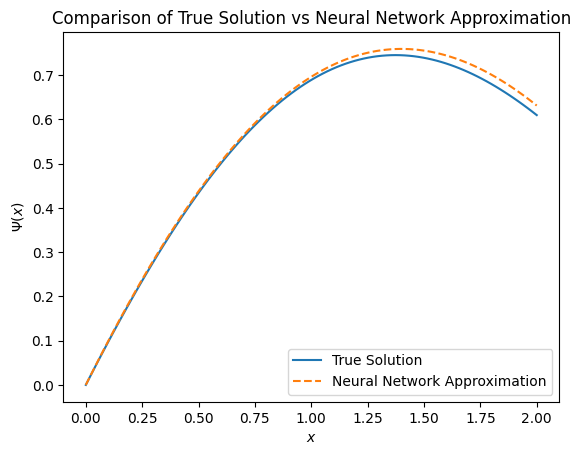

In [ ]:
# Generate a range of x-values for evaluating the true solution and its neural network approximation
x_values = np.linspace(0, 2, 100)[:, None]

# Evaluate the neural network's approximation over the generated x-values
with torch.no_grad():
    nn_approximation = Psi_t(torch.Tensor(x_values)).numpy()

# Calculate the true solution over the x-values
true_solution = np.exp(-x_values / 5.0) * np.sin(x_values)

# Plotting the results for comparison
fig, ax = plt.subplots(dpi=100)

# Plot the true solution
ax.plot(x_values, true_solution, label='True Solution')

# Plot the neural network approximation
ax.plot(x_values, nn_approximation, '--', label='Neural Network Approximation')

# Set axis labels and legend
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
ax.legend(loc='best')
plt.title('Comparison of True Solution vs Neural Network Approximation')
plt.show()

In [ ]:
pip install matplotlib


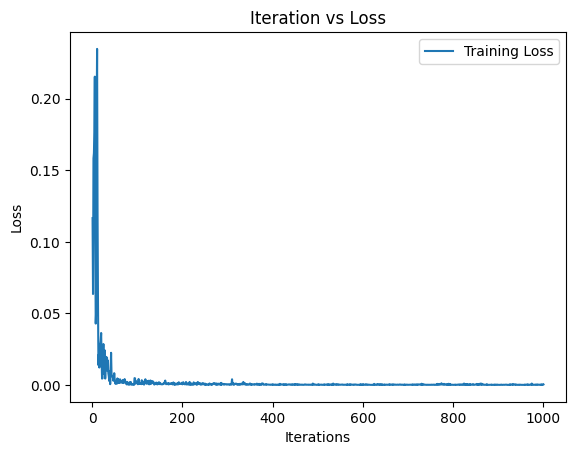

In [ ]:
# Plotting the iteration versus loss graph
plt.plot(iterations, loss_values, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Iteration vs Loss")
plt.legend()
plt.show()

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp

f = lambda x, Psi: np.exp(-x / 5.0) * np.cos(x) - Psi / 5.0

sol = solve_ivp(f, [0, 1], [0], method='RK45')

print(sol.y)


[[0.00000000e+00 9.99979999e-05 1.09975780e-03 1.10751579e-02
  1.08435188e-01 6.88938436e-01]]


Neural Network approximation vs RK45 solution

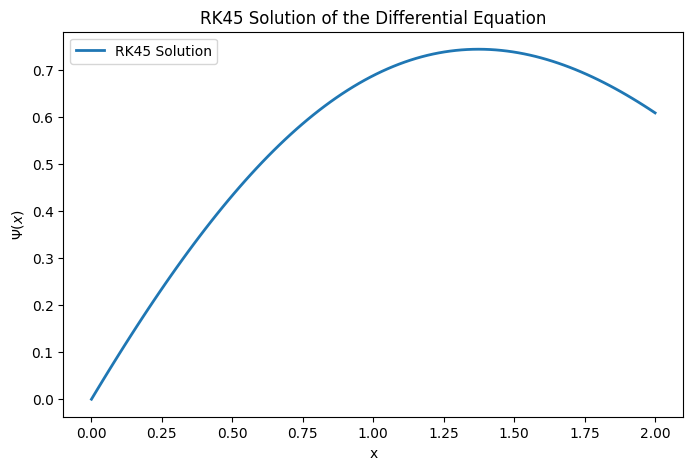

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Given initial condition
A = 0.

# Define the right-hand side of the differential equation
f = lambda x, Psi: np.exp(-x / 5.0) * np.cos(x) - Psi / 5.0

# Define the RK45 solver function
def ode_system(x, y):
    return f(x, y)

# Initial condition
initial_condition = [A]

# Time span for integration
t_span = (0, 2)

# Solve the ODE using RK45
sol_rk45 = solve_ivp(ode_system, t_span, initial_condition, method='RK45', t_eval=np.linspace(0, 2, 100))

# Plot the RK45 solution
plt.figure(figsize=(8, 5))
plt.plot(sol_rk45.t, sol_rk45.y[0], label='RK45 Solution', linewidth=2)
plt.xlabel('x')
plt.ylabel('$\Psi(x)$')
plt.legend()
plt.title('RK45 Solution of the Differential Equation')
plt.show()


Text(0.5, 1.0, 'Comparison of Neural Network Approximation and RK45 Solution')

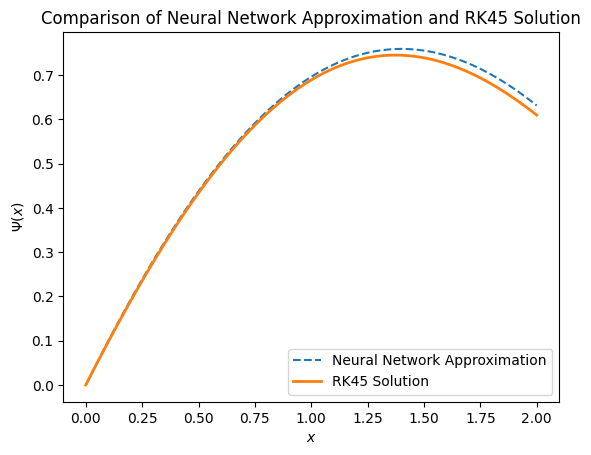

In [ ]:
# Generate a range of x-values for evaluating the neural network approximation
x_values = np.linspace(0, 2, 100)[:, None]

# Evaluate the neural network's approximation over the generated x-values
with torch.no_grad():
    nn_approximation = Psi_t(torch.Tensor(x_values)).numpy()

# Plotting the results for comparison
fig, ax = plt.subplots(dpi=100)

# Plot the neural network approximation
ax.plot(x_values, nn_approximation, '--', label='Neural Network Approximation')

# Set axis labels and legend
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
ax.legend(loc='best')
plt.title('Comparison of Neural Network Approximation and RK45 Solution')

# Solve the ODE using RK45
initial_condition = [A]
t_span = (0, 2)
sol_rk45 = solve_ivp(ode_system, t_span, initial_condition, method='RK45', t_eval=np.linspace(0, 2, 100))

# Plot the RK45 solution
ax.plot(sol_rk45.t, sol_rk45.y[0], label='RK45 Solution', linewidth=2)

# Set axis labels and legend
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
ax.legend(loc='best')
plt.title('Comparison of Neural Network Approximation and RK45 Solution')



---



---



Testing with the real problem

Final values:
x1: 0.7295462422601993
x2: 0.6240143958955232
x3: 0.32577222138663586
x4: 0.8740789883683628
u: 2.9998887207542264


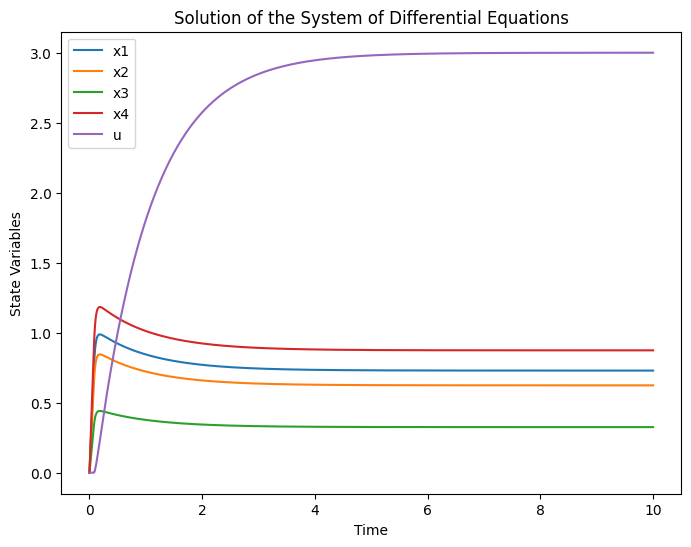

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the system of differential equations
def system(t, y):
    x1, x2, x3, x4, u = y
    dydt = [
       -(-9.54 + max(3.18*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0)),
       -(-8.16 + max(2.72*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0)),
       -(-4.26 + max(1.42*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0)),
       -(-11.43 + max(3.81*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81),0)),
        max((u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0) - u
    ]
    return dydt

# Initial condition
initial_condition = [0, 0, 0, 0, 0]

# Time points for output
t_values = np.linspace(0, 10, 1000)

# Solve the system of differential equations using RK45
# sol = solve_ivp(system, t_span=(0, 10), y0=initial_condition, method='RK45', t_eval=t_values)
sol = solve_ivp(system, t_span=(0, 10), y0=initial_condition, method='RK45', t_eval=t_values, rtol=1e-6, atol=1e-8)


# Extract the final values of x1, x2, x3, x4, and u
final_values = sol.y[:, -1]

# Print the final values
print("Final values:")
print("x1:", final_values[0])
print("x2:", final_values[1])
print("x3:", final_values[2])
print("x4:", final_values[3])
print("u:", final_values[4])

# Plot the solutions
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y.T)
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend(['x1', 'x2', 'x3', 'x4', 'u'])
plt.title('Solution of the System of Differential Equations')
plt.show()


Training the neural network...
Iteration 100 completed.
Iteration 200 completed.
Iteration 300 completed.
Iteration 400 completed.
Iteration 500 completed.
Iteration 600 completed.
Iteration 700 completed.
Iteration 800 completed.
Iteration 900 completed.
Iteration 1000 completed.
Iteration 1100 completed.
Iteration 1200 completed.
Iteration 1300 completed.
Iteration 1400 completed.
Iteration 1500 completed.
Iteration 1600 completed.
Iteration 1700 completed.
Iteration 1800 completed.
Iteration 1900 completed.
Iteration 2000 completed.
Iteration 2100 completed.
Iteration 2200 completed.
Iteration 2300 completed.
Iteration 2400 completed.
Iteration 2500 completed.
Iteration 2600 completed.
Iteration 2700 completed.
Iteration 2800 completed.
Iteration 2900 completed.
Iteration 3000 completed.
Iteration 3100 completed.
Iteration 3200 completed.
Iteration 3300 completed.
Iteration 3400 completed.
Iteration 3500 completed.
Iteration 3600 completed.
Iteration 3700 completed.
Iteration 3800 c

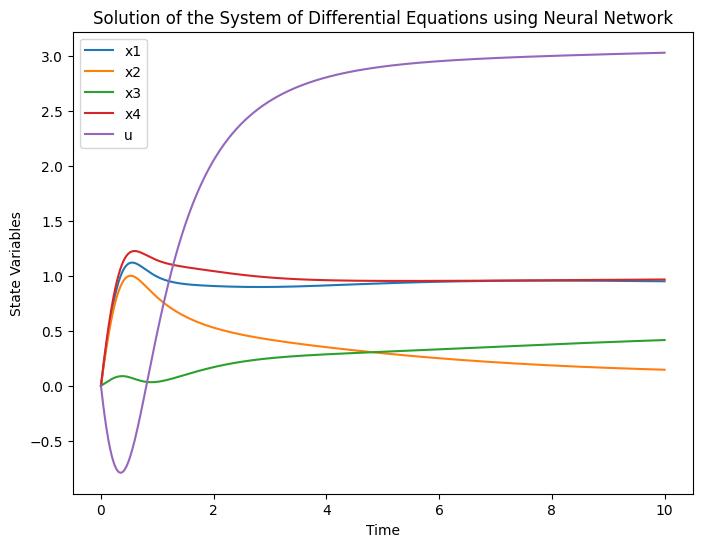

In [37]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(1, 100)
        self.layer2 = nn.Linear(100, 5, bias=False)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Tanh()(x)
        x = self.layer2(x)
        return x

# Initialize the neural network
N = NeuralNetwork()

# Given initial condition
A = torch.Tensor([0, 0, 0, 0, 0])

# Trial solution function using the neural network
def Psi_t(x):
    return A + (1 - torch.exp(-x)) * N(x)

def f(x, Psi):
    u, x1, x2, x3, x4 = Psi[:, 4], Psi[:, 0], Psi[:, 1], Psi[:, 2], Psi[:, 3]
    dydt = [
        -(-9.54 + torch.max(3.18*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0))),
        -(-8.16 + torch.max(2.72*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0))),
        -(-4.26 + torch.max(1.42*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0))),
        -(-11.43 + torch.max(3.81*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0))),
        torch.max((u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), torch.tensor(0.0)) - u
    ]

    return torch.stack(dydt, dim=1)

# Loss function for training the neural network
def loss(x):
    """Compute the loss based on the discrepancy between the ODE solution and its approximation."""
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

    # Ensure the sizes match by using the same batch size
    batch_size = x.shape[0]

    # Compute the loss only for the first 5 components (x1, x2, x3, x4, u)
    current_loss = torch.mean((Psi_t_x[:, :5] - f(x, outputs[:, :5])) ** 2)

    return current_loss

# Reinitialize the neural network (N) for fresh training
N = NeuralNetwork()

# Define the stochastic optimizer (Adam in this case)
adam_optimizer = torch.optim.Adam(N.parameters(), lr=0.001)

# Define the batch size (number of points to use per iteration) and maximum iterations
n_batch = 128
max_iterations = 5000

# Lists to store iteration and loss values for plotting
iterations = []
loss_values = []

print("Training the neural network...")

# Training loop
for iteration in range(max_iterations):
    # Randomly sample n_batch data points from the interval [0, 10]
    x_batch = 10 * torch.rand(n_batch, 1)

    # Reset the gradients
    adam_optimizer.zero_grad()

    # Compute the loss for the sampled batch
    current_loss = loss(x_batch)

    # Perform backpropagation to compute gradients
    current_loss.backward()

    # Update the neural network parameters
    adam_optimizer.step()

    # Append iteration and loss values for plotting
    iterations.append(iteration + 1)
    loss_values.append(current_loss.item())  # .item() extracts the scalar value from the tensor

    # Print the progress at regular intervals
    if iteration % 100 == 99:
        print(f"Iteration {iteration + 1} completed.")

print("Training completed.")

# Time points for output
t_values = np.linspace(0, 10, 1000)
# Use the trained neural network to predict the solution at different time points
y_predicted = Psi_t(torch.Tensor(t_values[:, None])).detach().numpy()

# Extract final values of x1, x2, x3, x4, and u
final_x1 = y_predicted[:, 0]
final_x2 = y_predicted[:, 1]
final_x3 = y_predicted[:, 2]
final_x4 = y_predicted[:, 3]
final_u = y_predicted[:, 4]

# Print the final values
print("Final values:")
print(f"x1: {final_x1[-1]}")
print(f"x2: {final_x2[-1]}")
print(f"x3: {final_x3[-1]}")
print(f"x4: {final_x4[-1]}")
print(f"u: {final_u[-1]}")

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t_values, y_predicted)
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend(['x1', 'x2', 'x3', 'x4', 'u'])
plt.title('Solution of the System of Differential Equations using Neural Network')
plt.show()


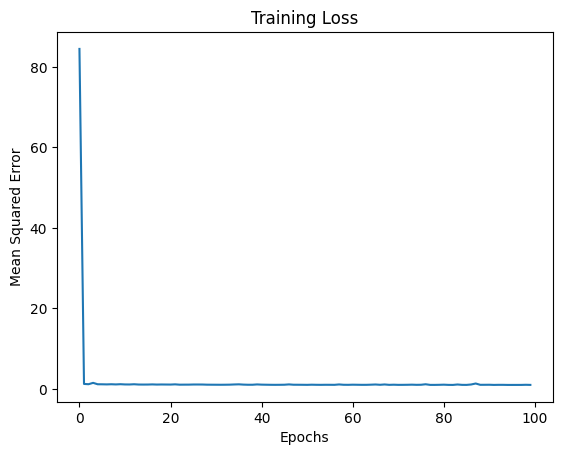

1/1 [==============================] - 0s 79ms/step - loss: 1.4786
Validation Loss: 1.4785597324371338
1/1 [==============================] - 0s 17ms/step - loss: 0.8935
Test Loss: 0.8934735059738159
1/1 [==============================] - 0s 51ms/step


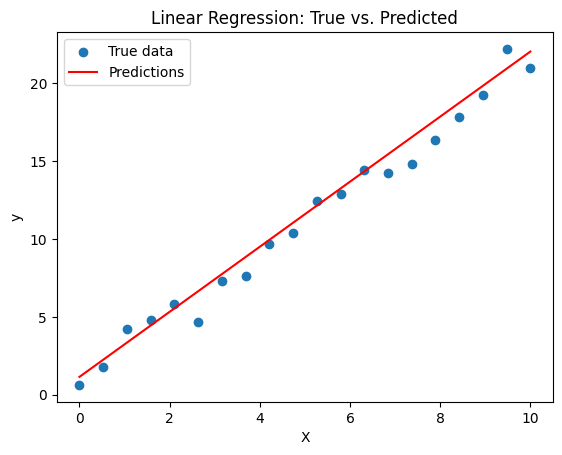

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Generate random data for linear regression
np.random.seed(0)
X_train = np.random.rand(100, 1) * 10
y_train = 2 * X_train + 1 + np.random.randn(100, 1)

# Define the linear regression model using TensorFlow
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), name='input_layer'),
    tf.keras.layers.Dense(units=1, activation='linear', name='output_layer')
])

# Compile the model
model.compile(optimizer='sgd', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, verbose=0)

# Plot the training loss over epochs
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

# Generate validation data
X_val = np.linspace(0, 10, 20).reshape(-1, 1)
y_val = 2 * X_val + 1 + np.random.randn(20, 1)

# Validate the model
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')

# Generate test data
X_test = np.linspace(0, 10, 20).reshape(-1, 1)
y_test = 2 * X_test + 1 + np.random.randn(20, 1)

# Test the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Visualize the results
y_pred = model.predict(X_test)

plt.scatter(X_test, y_test, label='True data')
plt.plot(X_test, y_pred, color='red', label='Predictions')
plt.title('Linear Regression: True vs. Predicted')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


Epoch 1/15000
25/25 [==============================] - 1s 6ms/step - loss: 1.8473 - val_loss: 1.2737
Epoch 2/15000
25/25 [==============================] - 0s 3ms/step - loss: 0.6955 - val_loss: 0.4333
Epoch 3/15000
25/25 [==============================] - 0s 2ms/step - loss: 0.1588 - val_loss: 0.0392
Epoch 4/15000
25/25 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0030
Epoch 5/15000
25/25 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 3.7928e-04
Epoch 6/15000
25/25 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 9.9666e-05
Epoch 7/15000
25/25 [==============================] - 0s 2ms/step - loss: 2.9242e-04 - val_loss: 1.8832e-05
Epoch 8/15000
25/25 [==============================] - 0s 3ms/step - loss: 1.2468e-04 - val_loss: 9.6171e-06
Epoch 9/15000
25/25 [==============================] - 0s 2ms/step - loss: 9.8823e-05 - val_loss: 7.3319e-07
Epoch 10/15000
25/25 [==============================] - 0s 

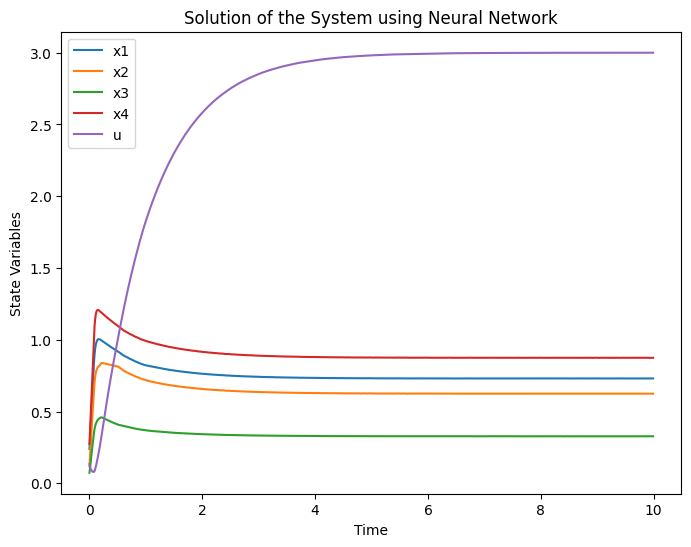

Final Predicted States:
x1: 0.7303072214126587
x2: 0.6243740916252136
x3: 0.32730114459991455
x4: 0.874126136302948
u:  2.9999067783355713


In [20]:
import numpy as np
from scipy.integrate import solve_ivp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define the system of differential equations
def system(t, y):
    x1, x2, x3, x4, u = y
    dydt = [
        -(-9.54 + max(3.18*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0)),
        -(-8.16 + max(2.72*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0)),
        -(-4.26 + max(1.42*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0)),
        -(-11.43 + max(3.81*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0)),
        max((u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0) - u
    ]
    return dydt

# Set initial conditions and time span
initial_condition = [0, 0, 0, 0, 0]
t_span = (0, 10)

# Generate training data using solve_ivp
sol = solve_ivp(system, t_span, initial_condition, method='RK45', dense_output=True)
t_values = np.linspace(0, 10, 1000)
y_values = sol.sol(t_values)

# Extract the training input (X_train) and target (y_train) data
X_train = y_values.T[:-1, :]  # Use states as input
y_train = y_values.T[1:, :]   # Use derivatives as target

# Define the neural network architecture
model = Sequential([
    Dense(32, activation='relu', input_shape=(5,)),
    Dense(32, activation='relu'),
    Dense(5)  # Output layer with 5 nodes for derivatives
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the neural network
history = model.fit(X_train, y_train, epochs=15000, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predict and integrate using the neural network
predicted_states = model.predict(X_train)

# Visualize the solutions
plt.figure(figsize=(8, 6))
plt.plot(t_values[:-1], predicted_states)
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend(['x1', 'x2', 'x3', 'x4', 'u'])
plt.title('Solution of the System using Neural Network')
plt.show()

final_predicted_states = predicted_states[-1, :]
print("Final Predicted States:")
print(f"x1: {final_predicted_states[0]}")
print(f"x2: {final_predicted_states[1]}")
print(f"x3: {final_predicted_states[2]}")
print(f"x4: {final_predicted_states[3]}")
print(f"u:  {final_predicted_states[4]}")




Epoch 1/15000
25/25 [==============================] - 3s 19ms/step - loss: 51.6423 - val_loss: 40.2455
Epoch 2/15000
25/25 [==============================] - 0s 4ms/step - loss: 35.9535 - val_loss: 32.5276
Epoch 3/15000
25/25 [==============================] - 0s 5ms/step - loss: 29.1239 - val_loss: 26.1201
Epoch 4/15000
25/25 [==============================] - 0s 4ms/step - loss: 22.1611 - val_loss: 17.7214
Epoch 5/15000
25/25 [==============================] - 0s 4ms/step - loss: 14.7829 - val_loss: 10.3417
Epoch 6/15000
25/25 [==============================] - 0s 4ms/step - loss: 8.2898 - val_loss: 4.6138
Epoch 7/15000
25/25 [==============================] - 0s 4ms/step - loss: 4.0399 - val_loss: 1.7604
Epoch 8/15000
25/25 [==============================] - 0s 5ms/step - loss: 2.1413 - val_loss: 0.8157
Epoch 9/15000
25/25 [==============================] - 0s 4ms/step - loss: 1.5795 - val_loss: 0.5326
Epoch 10/15000
25/25 [==============================] - 0s 5ms/step - loss: 1.36

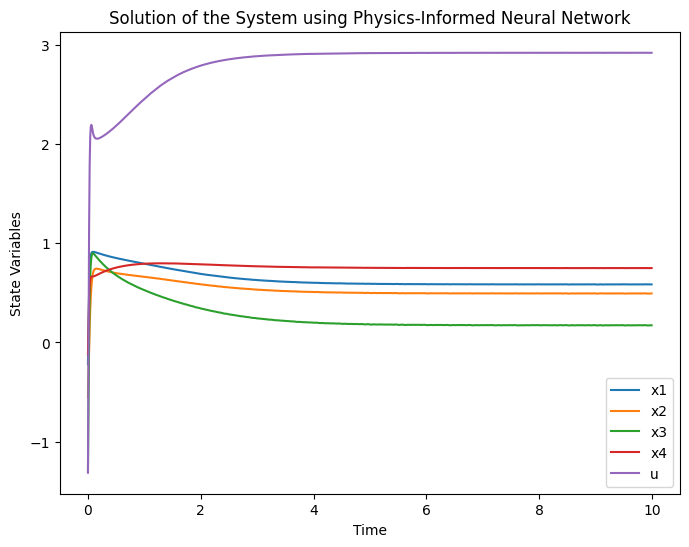

Final Predicted States:
x1: 0.5850334167480469
x2: 0.49364200234413147
x3: 0.17270876467227936
x4: 0.7497682571411133
u:  2.921121597290039


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the system of differential equations
def system(t, y):
    x1, x2, x3, x4, u = tf.unstack(y, axis=-1, num=5)

    dx1 = -(-9.54 + tf.maximum(3.18*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0))
    dx2 = -(-8.16 + tf.maximum(2.72*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0))
    dx3 = -(-4.26 + tf.maximum(1.42*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0))
    dx4 = -(-11.43 + tf.maximum(3.81*(u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0))
    du = tf.maximum((u + 3.18*x1 + 2.72*x2 + 1.42*x3 + 3.81*x4 - 7.81), 0) - u

    dydt = tf.stack([dx1, dx2, dx3, dx4, du], axis=-1)
    return dydt

# Generate training data using solve_ivp
t_span = (0, 10)
initial_condition = [0, 0, 0, 0, 0]
sol = solve_ivp(system, t_span, initial_condition, method='RK45', dense_output=True)
t_values = np.linspace(0, 10, 1000)
y_values = sol.sol(t_values)

# Define the PINN model
def create_pin_model():
    inputs = Input(shape=(5,))
    x = Dense(32, activation='tanh')(inputs)
    x = Dense(32, activation='tanh')(x)
    outputs = Dense(5)(x)
    return Model(inputs=inputs, outputs=outputs)

pin_model = create_pin_model()

# Define the loss function for the PINN
def pinn_loss(y_true, y_pred):
    # MSE loss for predicted states
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Physics-informed loss
    with tf.GradientTape() as tape:
        tape.watch(y_pred)
        t_pred = pin_model(y_pred)
    t_pred_gradients = tape.gradient(t_pred, y_pred)
    physics_loss = tf.reduce_mean(tf.square(t_pred_gradients - system(t_pred, y_pred)))

    return mse_loss + physics_loss

# Compile the PINN model
pin_model.compile(optimizer=Adam(learning_rate=0.001), loss=pinn_loss)

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the PINN model
history = pin_model.fit(y_values.T[:-1, :], y_values.T[1:, :], epochs=15000, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predict and integrate using the PINN
predicted_states = pin_model.predict(y_values.T[:-1, :])

# Visualize the solutions
plt.figure(figsize=(8, 6))
plt.plot(t_values[:-1], predicted_states)
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend(['x1', 'x2', 'x3', 'x4', 'u'])
plt.title('Solution of the System using Physics-Informed Neural Network')
plt.show()

final_predicted_states = predicted_states[-1, :]
print("Final Predicted States:")
print(f"x1: {final_predicted_states[0]}")
print(f"x2: {final_predicted_states[1]}")
print(f"x3: {final_predicted_states[2]}")
print(f"x4: {final_predicted_states[3]}")
print(f"u:  {final_predicted_states[4]}")
